# Music Matcher

A quick music recommender to find a song from library that matches with your seed preference.

## Importing

In [252]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import sklearn.preprocessing as skpp

## Dataset

Import tracks dataset: 

Source: scraped from spotify using spotify API

Note: This demo only contains small part of track data for illustration only.

### df_tracks contains the track meta info, with artist and album

In [253]:
df_tracks = pd.read_csv('sample_tracks_from_fulllist.csv', index_col=0)
print(df_tracks.shape)
df_tracks.head()

(19515, 8)


,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,track_uri
0,ABC,spotify:album:4GuzZh2dtsOjG3sMkx52eR,The Jackson 5,spotify:artist:2iE18Oxc8YSumAU232n4rW,174866,0,ABC,spotify:track:6cb0HzFQPN4BGADOmSzPCw
1,Everything Goes Numb,spotify:album:3phH2ZoACvpLVcPtyIk8jp,Streetlight Manifesto,spotify:artist:1OKOTYGoCE2buxTYMegJp7,327920,1,Point/Counterpoint,spotify:track:0HBvwy7XVhrkQljkCONgsq
2,Thriller 25 Super Deluxe Edition,spotify:album:1C2h7mLntPSeVYciMRTF4a,Michael Jackson,spotify:artist:3fMbdgg4jU18AjLCKBhRSm,293826,2,Billie Jean,spotify:track:5ChkMS8OtdzJeqyybCc9R5
3,Dookie,spotify:album:4uG8q3GPuWHQlRbswMIRS6,Green Day,spotify:artist:7oPftvlwr6VrsViSDV7fJY,181533,3,Basket Case,spotify:track:6L89mwZXSOwYl76YXfX13s
4,Elephant,spotify:album:4teFaDSeFHYXZjZJaZGrAO,The White Stripes,spotify:artist:4F84IBURUo98rz4r61KF70,231800,4,Seven Nation Army,spotify:track:1jNOi6m3Hn8nLEeHCp5Msr


### df_item_features contains the track item acoustic property info

In [254]:
df_item_features = pd.read_csv('extracted_track_list_marksample.csv')
print(df_item_features.shape)
df_item_features.head()

(13645, 18)


,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,6cb0HzFQPN4BGADOmSzPCw,0.572,0.786,8,-8.469,1,0.0642,0.51900,0.000930,0.1100,0.952,188.115,audio_features,spotify:track:6cb0HzFQPN4BGADOmSzPCw,https://api.spotify.com/v1/tracks/6cb0HzFQPN4B...,https://api.spotify.com/v1/audio-analysis/6cb0...,174867,4
1,0HBvwy7XVhrkQljkCONgsq,0.768,0.864,9,-5.286,1,0.0636,0.06220,0.000000,0.0822,0.813,129.809,audio_features,spotify:track:0HBvwy7XVhrkQljkCONgsq,https://api.spotify.com/v1/tracks/0HBvwy7XVhrk...,https://api.spotify.com/v1/audio-analysis/0HBv...,327920,4
2,5ChkMS8OtdzJeqyybCc9R5,0.920,0.654,11,-3.051,0,0.0401,0.02360,0.015800,0.0359,0.847,117.046,audio_features,spotify:track:5ChkMS8OtdzJeqyybCc9R5,https://api.spotify.com/v1/tracks/5ChkMS8OtdzJ...,https://api.spotify.com/v1/audio-analysis/5Chk...,293827,4
3,6L89mwZXSOwYl76YXfX13s,0.442,0.943,3,-3.205,1,0.0602,0.00293,0.000009,0.0910,0.781,85.064,audio_features,spotify:track:6L89mwZXSOwYl76YXfX13s,https://api.spotify.com/v1/tracks/6L89mwZXSOwY...,https://api.spotify.com/v1/audio-analysis/6L89...,181533,4
4,1jNOi6m3Hn8nLEeHCp5Msr,0.753,0.457,0,-7.709,1,0.0767,0.00679,0.484000,0.3110,0.297,123.913,audio_features,spotify:track:1jNOi6m3Hn8nLEeHCp5Msr,https://api.spotify.com/v1/tracks/1jNOi6m3Hn8n...,https://api.spotify.com/v1/audio-analysis/1jNO...,231800,4


## Data Cleaning and Feature Selection

Select only the useful columns for each dataset:

For df_tracks: select the identity features.

For df_item_features: select the numerical features.

In [255]:
df_tracks = df_tracks[['album_name', 'album_uri', 'artist_name', 'artist_uri','track_name', 'track_uri']]
df_item_features = df_item_features[['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo','duration_ms']]

In [256]:
df_tracks.isna().mean(axis=0)

album_name     0.000000
album_uri      0.000000
artist_name    0.000000
artist_uri     0.000000
track_name     0.000051
track_uri      0.001691
dtype: float64

In [257]:
df_item_features.isna().mean(axis=0)

id                  0.0
danceability        0.0
energy              0.0
key                 0.0
loudness            0.0
mode                0.0
speechiness         0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
tempo               0.0
duration_ms         0.0
dtype: float64

df_tracks has missing data in track_uri and track_name, drop those records.
Otherwise the datasets are quite clean.

In [258]:
df_tracks = df_tracks.dropna(axis=0)
df_tracks.shape

(19482, 6)

Item key to join: the suffix of track_uri in df_tracks, the id in df_item_features

In [259]:
# extract track id
df_tracks['track_id'] = df_tracks.apply(lambda x: x['track_uri'].split(':')[-1], axis=1)
# extract album id
df_tracks['album_id'] = df_tracks.apply(lambda x: x['album_uri'].split(':')[-1], axis=1)
# extract artist id
df_tracks['artist_id'] = df_tracks.apply(lambda x: x['artist_uri'].split(':')[-1], axis=1)
df_tracks.head()

,album_name,album_uri,artist_name,artist_uri,track_name,track_uri,track_id,album_id,artist_id
0,ABC,spotify:album:4GuzZh2dtsOjG3sMkx52eR,The Jackson 5,spotify:artist:2iE18Oxc8YSumAU232n4rW,ABC,spotify:track:6cb0HzFQPN4BGADOmSzPCw,6cb0HzFQPN4BGADOmSzPCw,4GuzZh2dtsOjG3sMkx52eR,2iE18Oxc8YSumAU232n4rW
1,Everything Goes Numb,spotify:album:3phH2ZoACvpLVcPtyIk8jp,Streetlight Manifesto,spotify:artist:1OKOTYGoCE2buxTYMegJp7,Point/Counterpoint,spotify:track:0HBvwy7XVhrkQljkCONgsq,0HBvwy7XVhrkQljkCONgsq,3phH2ZoACvpLVcPtyIk8jp,1OKOTYGoCE2buxTYMegJp7
2,Thriller 25 Super Deluxe Edition,spotify:album:1C2h7mLntPSeVYciMRTF4a,Michael Jackson,spotify:artist:3fMbdgg4jU18AjLCKBhRSm,Billie Jean,spotify:track:5ChkMS8OtdzJeqyybCc9R5,5ChkMS8OtdzJeqyybCc9R5,1C2h7mLntPSeVYciMRTF4a,3fMbdgg4jU18AjLCKBhRSm
3,Dookie,spotify:album:4uG8q3GPuWHQlRbswMIRS6,Green Day,spotify:artist:7oPftvlwr6VrsViSDV7fJY,Basket Case,spotify:track:6L89mwZXSOwYl76YXfX13s,6L89mwZXSOwYl76YXfX13s,4uG8q3GPuWHQlRbswMIRS6,7oPftvlwr6VrsViSDV7fJY
4,Elephant,spotify:album:4teFaDSeFHYXZjZJaZGrAO,The White Stripes,spotify:artist:4F84IBURUo98rz4r61KF70,Seven Nation Army,spotify:track:1jNOi6m3Hn8nLEeHCp5Msr,1jNOi6m3Hn8nLEeHCp5Msr,4teFaDSeFHYXZjZJaZGrAO,4F84IBURUo98rz4r61KF70


Check how many tracks are overlapping between the two datasets:

In [260]:
print(f'nunique tracks in df_tracks:{df_tracks["track_id"].nunique()},\
      and df_item_features:{df_item_features["id"].nunique()}')
print('overlapping nunique tracks of 2 datasets:',
      np.intersect1d(df_tracks['track_id'], df_item_features['id']).size)

nunique tracks in df_tracks:13625,      and df_item_features:13645
overlapping nunique tracks of 2 datasets: 13611


There is a good level of overlapping tracks between the two datasets, indicating high utilization efficiency of data.

Then, merge the two dataset into one:

In [261]:
df_tracks = pd.merge(df_tracks, df_item_features, how='inner', left_on='track_id', right_on='id')
display(df_tracks.head())
print(df_tracks.columns)

,album_name,album_uri,artist_name,artist_uri,track_name,track_uri,track_id,album_id,artist_id,id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,ABC,spotify:album:4GuzZh2dtsOjG3sMkx52eR,The Jackson 5,spotify:artist:2iE18Oxc8YSumAU232n4rW,ABC,spotify:track:6cb0HzFQPN4BGADOmSzPCw,6cb0HzFQPN4BGADOmSzPCw,4GuzZh2dtsOjG3sMkx52eR,2iE18Oxc8YSumAU232n4rW,6cb0HzFQPN4BGADOmSzPCw,...,8,-8.469,1,0.0642,0.5190,0.00093,0.1100,0.952,188.115,174867
1,ABC,spotify:album:4GuzZh2dtsOjG3sMkx52eR,The Jackson 5,spotify:artist:2iE18Oxc8YSumAU232n4rW,ABC,spotify:track:6cb0HzFQPN4BGADOmSzPCw,6cb0HzFQPN4BGADOmSzPCw,4GuzZh2dtsOjG3sMkx52eR,2iE18Oxc8YSumAU232n4rW,6cb0HzFQPN4BGADOmSzPCw,...,8,-8.469,1,0.0642,0.5190,0.00093,0.1100,0.952,188.115,174867
2,ABC,spotify:album:4GuzZh2dtsOjG3sMkx52eR,The Jackson 5,spotify:artist:2iE18Oxc8YSumAU232n4rW,ABC,spotify:track:6cb0HzFQPN4BGADOmSzPCw,6cb0HzFQPN4BGADOmSzPCw,4GuzZh2dtsOjG3sMkx52eR,2iE18Oxc8YSumAU232n4rW,6cb0HzFQPN4BGADOmSzPCw,...,8,-8.469,1,0.0642,0.5190,0.00093,0.1100,0.952,188.115,174867
3,Everything Goes Numb,spotify:album:3phH2ZoACvpLVcPtyIk8jp,Streetlight Manifesto,spotify:artist:1OKOTYGoCE2buxTYMegJp7,Point/Counterpoint,spotify:track:0HBvwy7XVhrkQljkCONgsq,0HBvwy7XVhrkQljkCONgsq,3phH2ZoACvpLVcPtyIk8jp,1OKOTYGoCE2buxTYMegJp7,0HBvwy7XVhrkQljkCONgsq,...,9,-5.286,1,0.0636,0.0622,0.00000,0.0822,0.813,129.809,327920
4,Thriller 25 Super Deluxe Edition,spotify:album:1C2h7mLntPSeVYciMRTF4a,Michael Jackson,spotify:artist:3fMbdgg4jU18AjLCKBhRSm,Billie Jean,spotify:track:5ChkMS8OtdzJeqyybCc9R5,5ChkMS8OtdzJeqyybCc9R5,1C2h7mLntPSeVYciMRTF4a,3fMbdgg4jU18AjLCKBhRSm,5ChkMS8OtdzJeqyybCc9R5,...,11,-3.051,0,0.0401,0.0236,0.01580,0.0359,0.847,117.046,293827


Index(['album_name', 'album_uri', 'artist_name', 'artist_uri', 'track_name',
       'track_uri', 'track_id', 'album_id', 'artist_id', 'id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')


Construct df_tracks with (artist, album and track) ids only, and move the (artist, album and track) names to a lookup dictionary.

In [262]:
dict_track_id_name = pd.Series(df_tracks.track_name.values, index=df_tracks.track_id).to_dict()
dict_album_id_name = pd.Series(df_tracks.album_name.values, index=df_tracks.album_id).to_dict()
dict_artist_id_name = pd.Series(df_tracks.artist_name.values, index=df_tracks.artist_id).to_dict()

dict_track_name_id = pd.Series(df_tracks.track_id.values, index=df_tracks.track_name).to_dict()
dict_album_name_id = pd.Series(df_tracks.album_id.values, index=df_tracks.album_name).to_dict()
dict_artist_name_id = pd.Series(df_tracks.artist_id.values, index=df_tracks.artist_name).to_dict()

Drop the useless columns and remove duplicated rows:

In [263]:
df_tracks = df_tracks.drop(['album_uri','artist_uri','track_uri','id'], axis=1)
df_tracks = df_tracks.drop_duplicates('track_id').reset_index(drop=True)
display(df_tracks.head())
df_tracks.shape, df_tracks['track_id'].nunique()

,album_name,artist_name,track_name,track_id,album_id,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,ABC,The Jackson 5,ABC,6cb0HzFQPN4BGADOmSzPCw,4GuzZh2dtsOjG3sMkx52eR,2iE18Oxc8YSumAU232n4rW,0.572,0.786,8,-8.469,1,0.0642,0.51900,0.000930,0.1100,0.952,188.115,174867
1,Everything Goes Numb,Streetlight Manifesto,Point/Counterpoint,0HBvwy7XVhrkQljkCONgsq,3phH2ZoACvpLVcPtyIk8jp,1OKOTYGoCE2buxTYMegJp7,0.768,0.864,9,-5.286,1,0.0636,0.06220,0.000000,0.0822,0.813,129.809,327920
2,Thriller 25 Super Deluxe Edition,Michael Jackson,Billie Jean,5ChkMS8OtdzJeqyybCc9R5,1C2h7mLntPSeVYciMRTF4a,3fMbdgg4jU18AjLCKBhRSm,0.920,0.654,11,-3.051,0,0.0401,0.02360,0.015800,0.0359,0.847,117.046,293827
3,Dookie,Green Day,Basket Case,6L89mwZXSOwYl76YXfX13s,4uG8q3GPuWHQlRbswMIRS6,7oPftvlwr6VrsViSDV7fJY,0.442,0.943,3,-3.205,1,0.0602,0.00293,0.000009,0.0910,0.781,85.064,181533
4,Elephant,The White Stripes,Seven Nation Army,1jNOi6m3Hn8nLEeHCp5Msr,4teFaDSeFHYXZjZJaZGrAO,4F84IBURUo98rz4r61KF70,0.753,0.457,0,-7.709,1,0.0767,0.00679,0.484000,0.3110,0.297,123.913,231800


((13611, 18), 13611)

Check for missing data:

Check on the distribution of each feature:

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_ms'}>]], dtype=object)

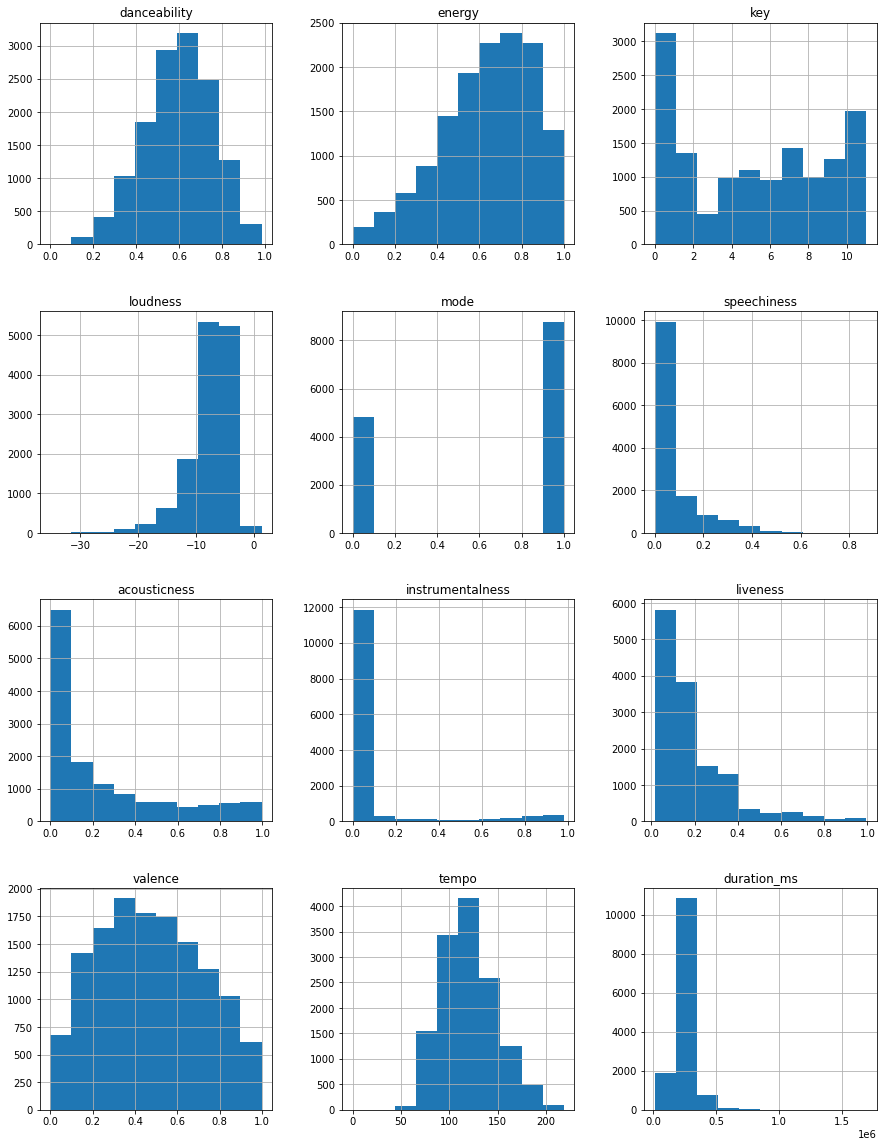

In [264]:
df_tracks.hist(figsize = (15,20))

We can observe that:
- loudness, speechiness, acousticness, instrumentalness, liveness and duration_ms are quite skewed.
- mode is binary either 0 or 1.

In [283]:
numerical_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms']
train_X = df_tracks[numerical_cols].values

Scale the numerical columns values to be within 0 and 1

In [284]:
scaler = skpp.MinMaxScaler()
train_X = scaler.fit_transform(train_X)

### Randomly generate seed tracks for user's input

In [324]:
num_seeds = 5
output_cols = ['track_name','artist_name','album_name']
seed_indeces = np.random.choice(train_X.shape[0],num_seeds)
display(df_tracks.loc[seed_indeces, output_cols])

,track_name,artist_name,album_name
6362,Canon in D,Valentinstag Romantik Musik,Valentinstag - Romantik Musik
7036,A Little Too Much,Shawn Mendes,Handwritten
13154,The Itsy Bitsy Spider,Nursery Rhymes,Nursery Rhymes
11051,Until You Were Gone,The Chainsmokers,The Chainsmokers- Japan Special Edition
7779,Gasoline,Halsey,BADLANDS


## KNN Model

In [314]:
# Specify the seed track
seed_index = 3419
seed_vector = train_X[seed_index].reshape(-1,1).T
print(df_tracks.loc[seed_index])

album_name            Doo-Wops & Hooligans
artist_name                     Bruno Mars
track_name            Just the Way You Are
track_id            7BqBn9nzAq8spo5e7cZ0dJ
album_id            1uyf3l2d4XYwiEqAb7t7fX
artist_id           0du5cEVh5yTK9QJze8zA0C
danceability                         0.637
energy                               0.843
key                                      5
loudness                            -5.413
mode                                     1
speechiness                         0.0432
acousticness                        0.0151
instrumentalness                       0.0
liveness                            0.0876
valence                              0.434
tempo                              109.012
duration_ms                         220733
Name: 3419, dtype: object


In [315]:
# Specify the number of neighbors for output
num_recs = 5

# Model Training
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=1+num_recs, n_jobs=-1)
model_knn.fit(train_X)

# Model Prediction
distances, indices = model_knn.kneighbors(seed_vector, n_neighbors = num_recs+1)
df_output = df_tracks.loc[indices[0][1:], output_cols]
df_output['score'] = 1-distances[0][1:]*10

### Output recommendation results:

In [316]:
df_output

,track_name,artist_name,album_name,score
4312,Fiction,Kygo,Cloud Nine,0.984744
298,The Way I Love Her,Stanaj,The Way I Love Her,0.979294
10668,Fire and the Flood,Vance Joy,Dream Your Life Away,0.978627
11784,God Is on the Move,7eventh Time Down,God Is on the Move,0.978435
11360,The Nights - Felix Jaehn Remix,Avicii,The Days / Nights,0.978342
